In [1]:
import os

In [2]:
from modules.pipeline import *

modules.report successfull loaded: 100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


In [3]:
from unidecode import unidecode

In [4]:
import matplotlib.pyplot as pl
from matplotlib.patches import Patch

In [5]:
import re

In [6]:
#!pip install --upgrade shap
from matplotlib.font_manager import FontProperties

In [7]:
import shap

In [8]:
from copy import deepcopy

In [9]:
svg = "<?xml version='1.0' ?><!DOCTYPE svg  PUBLIC '-//W3C//DTD SVG 1.1//EN'  'http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd'><svg enable-background='new 0 0 32 32' height='12px' id='Layer_1' version='1.1' viewBox='0 0 32 32' width='12px' xml:space='preserve' xmlns='http://www.w3.org/2000/svg' xmlns:xlink='http://www.w3.org/1999/xlink'><path d='M18.221,7.206l9.585,9.585c0.879,0.879,0.879,2.317,0,3.195l-0.8,0.801c-0.877,0.878-2.316,0.878-3.194,0  l-7.315-7.315l-7.315,7.315c-0.878,0.878-2.317,0.878-3.194,0l-0.8-0.801c-0.879-0.878-0.879-2.316,0-3.195l9.587-9.585  c0.471-0.472,1.103-0.682,1.723-0.647C17.115,6.524,17.748,6.734,18.221,7.206z' fill='#515151'/></svg>"
        

In [10]:
# coding: utf-8
import statistics

In [11]:
def get_filenames(root_dir, func, verbose=False):
    data_filenames = []
    # Walk through the directories and files
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # dirpath: current directory path
        # dirnames: list of directories in the current directory
        # filenames: list of files in the current directory

        # Print the current directory
        print('Directory:', dirpath)  if verbose else None
        # Print all the subdirectories
        if verbose:
            for dirname in dirnames:
                print('Subdirectory:', os.path.join(dirpath, dirname))

        # Print all the files
        for filename in filenames:
            if func(filename) and not ('x_' in filename or 'y_' in filename or 'metric' in filename):
                print('File:', os.path.join(dirpath, filename)) if verbose else None
                data_filenames.append(os.path.join(dirpath, filename))

        # Print an empty line to separate directories
        print()  if verbose else None
    return data_filenames

In [12]:
MLN_F = lambda x: (('classic_mln_' in x) and not('classic_mln_-' in x)) # find metric of model where mln were added
MLN__F = lambda x: (('classic_mln_-' in x)) # where mln attribut were removed first
MLN_C_F = lambda x: (('classic_-' in x)) # where mln attribut were removed first
MLN_C= lambda x: (('classic_' in x)) # where mln attribut were removed first

INTER_F = lambda x: (not('_max_' in x) and ('inter' in x))
INTRA_F = lambda x: (not('_max_' in x) and ('intra' in x))
COMBINE_F = lambda x: (not('_max_' in x) and ('combine' in x))
ULTRA_F = lambda x: (not('_max_' in x) and ('ultra' in x))
INTER_MAX_F = lambda x: (('_max_' in x) and ('inter' in x))
INTRA_MAX_F = lambda x: (('_max_' in x) and ('intra' in x))
COMBINE_MAX_F = lambda x: (('_max_' in x) and ('combine' in x))
ULTRA_MAX_F = lambda x: (('_max_' in x) and ('ultra' in x))
DEGREE_F = lambda x: (('degree' in x))

In [13]:
def metrics_analyzer_statistics_tab_f_1(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        head_lambda = lambda x: f'<tr><td colspan="2" rowspan="2">{x}</td><td colspan="2">Accuracy</td><td colspan="2">Precision</td><td colspan="2">Recall</td><td colspan="2">F1-score</td></tr><tr>{"<td>G</td><td>P</td>"*4}</tr>'
        tab1_head = head_lambda(data_folder)
        tab1_body = ""
        metrics = {
            'accuracy': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            },
            'precision': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            },
            'recall': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            },
            'f1-score': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            }
        }

        totalImpact = {
            'accuracy': {
                    'P':[],
                    'G':[]
                },
            'precision': {
                    'P':[],
                    'G':[]
                },
            'recall': {
                    'P':[],
                    'G':[]
                },
            'f1-score': {
                    'P':[],
                    'G':[]
                }
        }
        
        dictio = {
                    'classic_-_mlna': 'Classic - Att',
                    'classic_mln': 'Classic + MLN',
                    'classic_mln_-_mlna': 'Classic + MLN - Att',
                    'classic': 'Classic'
                }
        
        
        style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
        caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
            **models_name,
            'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
            'Att': 'Attributs or modalities of variable(s) used to build MLN',
            'MLN': 'Descriptors extracted from MLN',
            'Classic': f'Learning from classic dataset of {data_folder}',
            'Classic - Att': f'Learning from classic dataset of {data_folder} where Att had been removed',
            'Classic + MLN': f'Learning from classic dataset of {data_folder} where MLN had been added',
            'Classic + MLN - Att': f'Learning from classic dataset of {data_folder} where MLN had been added and Att removed'
            }.items()])
        
        tab1_body_model = {key: deepcopy(metrics) for key in models_name.keys()}

        # fetch layers
        for k in layers:
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic': classic_metrics,
                        #'classic_-_mlna':[
                        #    load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        #    for file in get_filenames(
                        #        root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                        #        func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                        #        verbose=False
                         #       )
                         #   ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic': classic_metrics,
                       # 'classic_-_mlna':[
                       #     load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                       #     for file in get_filenames(
                       #         root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                       #         func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                       #         verbose=False
                       #         )
                       #     ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic'].index.values.tolist()
                print(models_list)
                metrics = ["accuracy","precision","recall","f1-score"]
                
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for metric in metrics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # add metric in the vector
                            tab1_body_model[model][metric][key]['G'].append(round(files['global'][key].loc[model,metric],4))
                            tab1_body_model[model][metric][key]['P'].append(round(files['personalized'][key].loc[model,metric],4))
                            #totalImpact[metric]["P"].append(tab1_body_model[model][metric][key]['P'] >= tab1_body_model[model][metric][key]['G'])
                            #totalImpact[metric]["G"].append(tab1_body_model[model][metric][key]['P'] <= tab1_body_model[model][metric][key]['P'])
        
        # fetch each model
        for model in models_list:
            tab1_body+= f'<tr> <td rowspan="2">{model}</td>'
            # fetch approach
            for i, key in enumerate(files['global'].keys() if approach == None else approach):
                # fetch evaluation metric
                tab1_body+= f'<tr> <td>{dictio[key]}</td>' if i != 0 else f'<td>{dictio[key]}</td>'
                for y, metric in enumerate(metrics):
                    # add metric in the vector
                    totalImpact[metric]["P"].append(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))
                    totalImpact[metric]["G"].append(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))
        
                    tab1_body+= (f'<td>{"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["G"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}</td>'+
                                f'<td> {"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["P"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}</td>'
                                ) if y != len(metrics)-1 else (f'<td>{"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["G"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}</td>'+
                                f'<td> {"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["P"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}</td></tr>')
        tab1_body+= f'<tr> <td colspan="2">Total</td>'
        for y, metric in enumerate(metrics): 
            tab1_body+= (f'<td>{"<strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["G"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}</td>'+
                            f'<td>{"<strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["P"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}</td>'
                            ) if y != len(metrics)-1 else (f'<td>{"<strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["G"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}</td>'+
                            f'<td>{"<strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["P"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}</td></tr>')
            
        
        caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
        table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{caption}{tab1_head}{tab1_body}</table>'
        htm = f'<html><head>{style}<title> Best metrics of personalized and global logic for Classic + MLN et Classic + MLN - Att pour chaque modèle </title></head><body style="background-color: white;">{table_html}</body></html>'
        
        create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab1')
        timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab1/Statistical comparaison of approachs in {data_folder} on global logic'+'_'+timestr+'.html'
        _file= open(filename1,"w")
        _file.write(htm)
        _file.close()
        

In [13]:
get_qualitative_from_cols = lambda x:(list(set([
    var.split("__")[1] for var in [
        coll 
        for coll in [
            col 
            for col in x 
                if not (
                    ('precision' in col ) 
                    or ('accuracy' in col ) 
                    or ('recall' in col) 
                    or ('f1-score' in col)
                )
            ] 
            if ("__" in coll)
        ]
    ]
)))

In [14]:
def analyzer_launcher(outputs_name=None, analytical_func=None, layers=None, approach=None, aggregation_f=None):
    
    result_folders = [dirnames for _, dirnames, _ in os.walk(f'{os.getcwd()}/{outputs_name}')][0]
    for dataset_name in result_folders:
        print(dataset_name)
        classic_f = [
                        load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        for file in get_filenames(
                            root_dir=f'{os.getcwd()}/{outputs_name}/{dataset_name}/data_selection_storage', 
                            func=MLN_C, 
                            verbose=False
                            )
                        ][-1]
        quali_col = get_qualitative_from_cols(classic_f.columns.to_list())
        models_list = classic_f.index.values.tolist()
        models = model_desc()
        models_name = { key : models[key] for key in models.keys() if key in models_list}
        layers = list(set([1, 2, len(quali_col)]))
        analytical_func(
            cols=quali_col, 
            outputs_path=f'{os.getcwd()}/{outputs_name}/{dataset_name}', 
            cwd=os.getcwd(), 
            data_folder=dataset_name, 
            classic_metrics=classic_f, 
            models_name=models_name,
            layers= layers if layers != None else list(set([1, 2, len(quali_col)])), 
            approach= approach
            ) if aggregation_f == None else analytical_func(
            cols=quali_col, 
            outputs_path=f'{os.getcwd()}/{outputs_name}/{dataset_name}', 
            cwd=os.getcwd(), 
            data_folder=dataset_name, 
            classic_metrics=classic_f, 
            models_name=models_name,
            layers= layers if layers != None else list(set([1, 2, len(quali_col)])), 
            approach= approach,
            aggregation_f=aggregation_f
            )
        

In [16]:
layers = None
approach = ['classic_mln','classic_mln_-_mlna']

In [17]:
analyzer_launcher(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_1, layers=layers, approach=approach)

AER
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AER/plots/fnTab/tab1' created successfully.
AFB
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AFB/plots/fnTab/tab1' created successfully.
CREDIT_RISK_DATASET
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc',

In [18]:
def metrics_analyzer_statistics_tab_f_2(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        mlnL = {f'MLN {key if i != len(layers) - 1 else "All"}': {
                    'P':[],
                    'G':[]
                } for i, key in enumerate(layers)}
        totalImpact = {
            'accuracy': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)},
            'precision': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)},
            'recall': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)},
            'f1-score': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)}
        }
        head_lambda = lambda x: f'<tr><td colspan="3" rowspan="2">{x}</td><td colspan="{len(mlnL)}">Accuracy</td><td colspan="{len(mlnL)}">Precision</td><td colspan="{len(mlnL)}">Recall</td><td colspan="{len(mlnL)}">F1-score</td></tr><tr>{"".join(["<td>"+key+"</td>" for key in mlnL.keys()]) *4}</tr>'
        tab1_head = head_lambda(data_folder)
        tab1_body = ""
        
        metrics = {
            'accuracy': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            },
            'precision': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            },
            'recall': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            },
            'f1-score': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            }
        }
        
            
        dictio = {
            'classic_-_mlna': 'Classic - Att',
            'classic_mln': 'Classic + MLN',
            'classic_mln_-_mlna': 'Classic + MLN - Att',
            'classic': 'Classic'
        }
        
        style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
        caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
            **models_name,
            'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
            'Att': 'Attributs or modalities of variable(s) used to build MLN',
            'MLN': 'Descriptors extracted from MLN',
            'Classic': f'Learning from classic dataset of {data_folder}',
            'Classic - Att': f'Learning from classic dataset of {data_folder} where Att had been removed',
            'Classic + MLN': f'Learning from classic dataset of {data_folder} where MLN had been added',
            'Classic + MLN - Att': f'Learning from classic dataset of {data_folder} where MLN had been added and Att removed'
            }.items()])
        
        tab1_body_model = {key: deepcopy(metrics) for key in models_name.keys()}

        # fetch layers
        for d, k in enumerate(layers):
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic': classic_metrics,
                        #'classic_-_mlna':[
                        #    load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        #    for file in get_filenames(
                        #        root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                        #        func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                        #        verbose=False
                         #       )
                         #   ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic': classic_metrics,
                       # 'classic_-_mlna':[
                       #     load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                       #     for file in get_filenames(
                       #         root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                       #         func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                       #         verbose=False
                       #         )
                       #     ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic'].index.values.tolist()
                print(models_list)
                metrics = ["accuracy","precision","recall","f1-score"]
                
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for metric in metrics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # add metric in the vector
                            tab1_body_model[model][metric][key][f'MLN {k if d != len(layers) - 1 else "All"}']["G"].append(round(files['global'][key].loc[model,metric],4))
                            tab1_body_model[model][metric][key][f'MLN {k if d != len(layers) - 1 else "All"}']["P"].append(round(files['personalized'][key].loc[model,metric],4))
                            
        logics = {"G":"Global","P":"Personalized"}    
        # fetch each model
        for model in models_list:
                tab1_body+= f'<tr> <td rowspan="4">{model}</td>'
                # fetch approach
                for i, key in enumerate(files['global'].keys() if approach == None else approach):
                    # fetch evaluation metric
                    tab1_body+= (f'<tr> <td rowspan="2">{dictio[key]}</td>') if i != 0 else (f'<td rowspan="2">{dictio[key]}</td>')
                    for l,logic in enumerate(logics.keys()):
                        tab1_body+= (f'<tr><td>{logics[logic]}</td>') if l != 0 else (f'<td>{logics[logic]}</td>')
                        for y, metric in enumerate(metrics):
                            #print(f"{y}--")
                            # fetch layers
                            for z, layer in enumerate(mlnL.keys()):
                                #print(f"{z};")
                                # add metric in the vector
                                maxi = [max(tab1_body_model[model][metric][key][lay][logic]) for lay in mlnL ]
                                totalImpact[metric][layer].append(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))
                    
                                tab1_body+= (f'<td>{"<strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}{max(tab1_body_model[model][metric][key][layer][logic])}{"</strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}</td></tr>') if ((y == len(metrics)-1) and (z == len(mlnL)-1 )) else (
                                            f'<td>{"<strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}{max(tab1_body_model[model][metric][key][layer][logic])}{"</strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}</td>')
                            
        tab1_body+= f'<tr> <td colspan="3">Total</td>'
        for y, metric in enumerate(metrics): 
            for z, layer in enumerate(mlnL.keys()):
                maxi = [sum(totalImpact[metric][lay]) for lay in mlnL]
                tab1_body+= (f'<td>{"<strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}{sum(totalImpact[metric][layer])}{"</strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}</td></tr>'
                                ) if ((y == len(metrics)-1) and (z == len(mlnL)-1 )) else (
                                f'<td>{"<strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}{sum(totalImpact[metric][layer])}{"</strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}</td>')
        
        caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
        table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{caption}{tab1_head}{tab1_body}</table>'
        htm = f'<html><head>{style}<title> Best metrics of personalized and global logic for Classic + MLN et Classic + MLN - Att pour chaque modèle et modélisation </title></head><body style="background-color: white;">{table_html}</body></html>'
        
        create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab2')
        timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab2/Statistical comparaison of approachs in {data_folder} on global logic'+'_'+timestr+'.html'
        _file= open(filename1,"w")
        _file.write(htm)
        _file.close()
        

In [19]:
analyzer_launcher(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_2, layers=layers, approach=approach)

AER
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AER/plots/fnTab/tab2' created successfully.
AFB
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AFB/plots/fnTab/tab2' created successfully.
CREDIT_RISK_DATASET
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc',

In [20]:
def metrics_analyzer_statistics_tab_f_3(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        head_lambda = lambda x: f'<tr><td colspan="2" rowspan="2">{x}</td><td colspan="3">Accuracy</td><td colspan="3">Precision</td><td colspan="3">Recall</td><td colspan="3">F1-score</td></tr><tr>{("<td>Classic</td><td>G"+svg+"</td><td>P"+svg+"</td>")*4}</tr>'
        tab1_head = head_lambda(data_folder)
        tab1_body = ""
        metrics = {
            'accuracy': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            },
            'precision': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            },
            'recall': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            },
            'f1-score': {
                'classic_mln':{
                    'P':[],
                    'G':[]
                },
                'classic_mln_-_mlna':{
                    'P':[],
                    'G':[]
                }
            }
        }

        totalImpact = {
            'accuracy': {
                    'P':[],
                    'G':[]
                },
            'precision': {
                    'P':[],
                    'G':[]
                },
            'recall': {
                    'P':[],
                    'G':[]
                },
            'f1-score': {
                    'P':[],
                    'G':[]
                }
        }
        
        dictio = {
                    'classic_-_mlna': 'Classic - Att',
                    'classic_mln': 'Classic + MLN',
                    'classic_mln_-_mlna': 'Classic + MLN - Att',
                    'classic': 'Classic'
                }
        
        
        style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
        caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
            **models_name,
            'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
            'Att': 'Attributs or modalities of variable(s) used to build MLN',
            'MLN': 'Descriptors extracted from MLN',
            'Classic': f'Learning from classic dataset of {data_folder}',
            'Classic - Att': f'Learning from classic dataset of {data_folder} where Att had been removed',
            'Classic + MLN': f'Learning from classic dataset of {data_folder} where MLN had been added',
            'Classic + MLN - Att': f'Learning from classic dataset of {data_folder} where MLN had been added and Att removed'
            }.items()])
        
        tab1_body_model = {key: deepcopy(metrics) for key in models_name.keys()}

        # fetch layers
        for k in layers:
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic': classic_metrics,
                        #'classic_-_mlna':[
                        #    load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        #    for file in get_filenames(
                        #        root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                        #        func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                        #        verbose=False
                         #       )
                         #   ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic': classic_metrics,
                       # 'classic_-_mlna':[
                       #     load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                       #     for file in get_filenames(
                       #         root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                       #         func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                       #         verbose=False
                       #         )
                       #     ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic'].index.values.tolist()
                print(models_list)
                metrics = ["accuracy","precision","recall","f1-score"]
                
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for metric in metrics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # add metric in the vector
                            tab1_body_model[model][metric][key]['G'].append(round(((round(files['global'][key].loc[model,metric],4) - round(files['global']['classic'].loc[model,metric],4))/round(files['global']['classic'].loc[model,metric],4))*100,4) if round(((round(files['global'][key].loc[model,metric],4) - round(files['global']['classic'].loc[model,metric],4))/round(files['global']['classic'].loc[model,metric],4))*100,4) >= 0 else 0.0)
                            tab1_body_model[model][metric][key]['P'].append(round(((round(files['personalized'][key].loc[model,metric],4) - round(files['personalized']['classic'].loc[model,metric],4))/round(files['personalized']['classic'].loc[model,metric],4))*100,4) if round(((round(files['personalized'][key].loc[model,metric],4) - round(files['personalized']['classic'].loc[model,metric],4))/round(files['personalized']['classic'].loc[model,metric],4))*100,4) >= 0 else 0.0)
                            #totalImpact[metric]["P"].append(tab1_body_model[model][metric][key]['P'] >= tab1_body_model[model][metric][key]['G'])
                            #totalImpact[metric]["G"].append(tab1_body_model[model][metric][key]['P'] <= tab1_body_model[model][metric][key]['P'])
        
        # fetch each model
        for model in models_list:
            tab1_body+= f'<tr> <td rowspan="2">{model}</td>'
            # fetch approach
            for i, key in enumerate(files['global'].keys() if approach == None else approach):
                # fetch evaluation metric
                tab1_body+= f'<tr> <td>{dictio[key]}</td>' if i != 0 else f'<td>{dictio[key]}</td>'
                for y, metric in enumerate(metrics):
                    # add metric in the vector
                    totalImpact[metric]["P"].append(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))
                    totalImpact[metric]["G"].append(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))
        
                    tab1_body+= (f'<td>{round(files["global"]["classic"].loc[model,metric],4)}</td><td>{"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["G"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}</td>'+
                                f'<td> {"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["P"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}</td>'
                                ) if y != len(metrics)-1 else (f'<td>{round(files["global"]["classic"].loc[model,metric],4)}</td><td>{"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["G"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) >= max(tab1_body_model[model][metric][key]["P"]))}</td>'+
                                f'<td> {"<strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}{max(tab1_body_model[model][metric][key]["P"])}{"</strong>"*int(max(tab1_body_model[model][metric][key]["G"]) <= max(tab1_body_model[model][metric][key]["P"]))}</td></tr>')
        tab1_body+= f'<tr> <td colspan="2">Total</td>'
        for y, metric in enumerate(metrics): 
            tab1_body+= (f'<td></td><td>{"<strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["G"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}</td>'+
                            f'<td>{"<strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["P"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}</td>'
                            ) if y != len(metrics)-1 else (f'<td></td><td>{"<strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["G"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) >= sum(totalImpact[metric]["P"]))}</td>'+
                            f'<td>{"<strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}{sum(totalImpact[metric]["P"])}{"</strong>"*int(sum(totalImpact[metric]["G"]) <= sum(totalImpact[metric]["P"]))}</td></tr>')
            
        
        caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
        table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{caption}{tab1_head}{tab1_body}</table>'
        htm = f'<html><head>{style}<title> Best outperforming metrics of personalized and global logic for Classic + MLN et Classic + MLN - Att pour chaque modèle </title></head><body style="background-color: white;">{table_html}</body></html>'
        
        create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab3')
        timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab3/Statistical comparaison of approachs in {data_folder} on global logic'+'_'+timestr+'.html'
        _file= open(filename1,"w")
        _file.write(htm)
        _file.close()
        

In [21]:
analyzer_launcher(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_3, layers=layers, approach=approach)

AER
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AER/plots/fnTab/tab3' created successfully.
AFB
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AFB/plots/fnTab/tab3' created successfully.
CREDIT_RISK_DATASET
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc',

In [22]:
def metrics_analyzer_statistics_tab_f_4(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        mlnL = {f'MLN {key if i != len(layers) - 1 else "All"}': {
                    'P':[],
                    'G':[]
                } for i, key in enumerate(layers)}
        totalImpact = {
            'accuracy': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)},
            'precision': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)},
            'recall': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)},
            'f1-score': {f'MLN {key if i != len(layers) - 1 else "All"}': [] for i, key in enumerate(layers)}
        }
        ele = "".join(["<td>"+key+""+svg+"</td>" for key in mlnL.keys()])
        head_lambda = lambda x: f'<tr><td colspan="3" rowspan="2">{x}</td><td colspan="{len(mlnL)+1}">Accuracy</td><td colspan="{len(mlnL)+1}">Precision</td><td colspan="{len(mlnL)+1}">Recall</td><td colspan="{len(mlnL)+1}">F1-score</td></tr><tr>{("<td>classic</td>"+ele) *4}</tr>'
        tab1_head = head_lambda(data_folder)
        tab1_body = ""
        
        metrics = {
            'accuracy': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            },
            'precision': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            },
            'recall': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            },
            'f1-score': {
                'classic_mln':deepcopy(mlnL),
                'classic_mln_-_mlna':deepcopy(mlnL)
            }
        }
        
            
        dictio = {
            'classic_-_mlna': 'Classic - Att',
            'classic_mln': 'Classic + MLN',
            'classic_mln_-_mlna': 'Classic + MLN - Att',
            'classic': 'Classic'
        }
        
        style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
        caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
            **models_name,
            'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
            'Att': 'Attributs or modalities of variable(s) used to build MLN',
            'MLN': 'Descriptors extracted from MLN',
            'Classic': f'Learning from classic dataset of {data_folder}',
            'Classic - Att': f'Learning from classic dataset of {data_folder} where Att had been removed',
            'Classic + MLN': f'Learning from classic dataset of {data_folder} where MLN had been added',
            'Classic + MLN - Att': f'Learning from classic dataset of {data_folder} where MLN had been added and Att removed'
            }.items()])
        
        tab1_body_model = {key: deepcopy(metrics) for key in models_name.keys()}

        # fetch layers
        for d, k in enumerate(layers):
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic': classic_metrics,
                        #'classic_-_mlna':[
                        #    load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        #    for file in get_filenames(
                        #        root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                        #        func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                        #        verbose=False
                         #       )
                         #   ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic': classic_metrics,
                       # 'classic_-_mlna':[
                       #     load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                       #     for file in get_filenames(
                       #         root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                       #         func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                       #         verbose=False
                       #         )
                       #     ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic'].index.values.tolist()
                print(models_list)
                metrics = ["accuracy","precision","recall","f1-score"]
                
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for metric in metrics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # add metric in the vector
                            tab1_body_model[model][metric][key][f'MLN {k if d != len(layers) - 1 else "All"}']["G"].append(round(((round(files['global'][key].loc[model,metric],4) - round(files['global']['classic'].loc[model,metric],4))/round(files['global']['classic'].loc[model,metric],4))*100,4) if round(((round(files['global'][key].loc[model,metric],4) - round(files['global']['classic'].loc[model,metric],4))/round(files['global']['classic'].loc[model,metric],4))*100,4) >= 0 else 0.0)
                            tab1_body_model[model][metric][key][f'MLN {k if d != len(layers) - 1 else "All"}']["P"].append(round(((round(files['personalized'][key].loc[model,metric],4) - round(files['personalized']['classic'].loc[model,metric],4))/round(files['personalized']['classic'].loc[model,metric],4))*100,4) if round(((round(files['personalized'][key].loc[model,metric],4) - round(files['personalized']['classic'].loc[model,metric],4))/round(files['personalized']['classic'].loc[model,metric],4))*100,4) >= 0 else 0.0)
                            
        logics = {"G":"Global","P":"Personalized"}    
        # fetch each model
        for model in models_list:
                tab1_body+= f'<tr> <td rowspan="4">{model}</td>'
                # fetch approach
                for i, key in enumerate(files['global'].keys() if approach == None else approach):
                    # fetch evaluation metric
                    tab1_body+= (f'<tr> <td rowspan="2">{dictio[key]}</td>') if i != 0 else (f'<td rowspan="2">{dictio[key]}</td>')
                    for l,logic in enumerate(logics.keys()):
                        tab1_body+= (f'<tr><td>{logics[logic]}</td>') if l != 0 else (f'<td>{logics[logic]}</td>')
                        for y, metric in enumerate(metrics):
                            #print(f"{y}--")
                            # fetch layers
                            for z, layer in enumerate(mlnL.keys()):
                                #print(f"{z};")
                                # add metric in the vector
                                maxi = [max(tab1_body_model[model][metric][key][lay][logic]) for lay in mlnL ]
                                totalImpact[metric][layer].append(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))
                                prefix = f'<td>{round(files["global"]["classic"].loc[model,metric],4)}</td>' if z == 0 else ""
                                tab1_body+= (f'{prefix}<td>{"<strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}{max(tab1_body_model[model][metric][key][layer][logic])}{"</strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}</td></tr>') if ((y == len(metrics)-1) and (z == len(mlnL)-1 )) else (
                                            f'{prefix}<td>{"<strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}{max(tab1_body_model[model][metric][key][layer][logic])}{"</strong>"*int(max(tab1_body_model[model][metric][key][layer][logic]) == max(maxi))}</td>')
                            
        tab1_body+= f'<tr> <td colspan="3">Total</td>'
        for y, metric in enumerate(metrics): 
            for z, layer in enumerate(mlnL.keys()):
                maxi = [sum(totalImpact[metric][lay]) for lay in mlnL]
                prefix = "<td></td>" if z == 0 else ""
                tab1_body+= (f'{prefix}<td>{"<strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}{sum(totalImpact[metric][layer])}{"</strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}</td></tr>'
                                ) if ((y == len(metrics)-1) and (z == len(mlnL)-1 )) else (
                                f'{prefix}<td>{"<strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}{sum(totalImpact[metric][layer])}{"</strong>"*int(sum(totalImpact[metric][layer]) == max(maxi))}</td>')
        
        caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
        table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{caption}{tab1_head}{tab1_body}</table>'
        htm = f'<html><head>{style}<title> Best outperforming metrics of personalized and global logic for Classic + MLN et Classic + MLN - Att pour chaque modèle et modélisation </title></head><body style="background-color: white;">{table_html}</body></html>'
        
        create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab4')
        timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/fnTab/tab4/Statistical comparaison of approachs in {data_folder} on global logic'+'_'+timestr+'.html'
        _file= open(filename1,"w")
        _file.write(htm)
        _file.close()
        

In [23]:
analyzer_launcher(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_4, layers=layers, approach=approach)

AER
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AER/plots/fnTab/tab4' created successfully.
AFB
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AFB/plots/fnTab/tab4' created successfully.
CREDIT_RISK_DATASET
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc',

In [14]:
def custom_color(list_col, graph_a=[]):
    colors= []
    for col in list_col:
        if col in graph_a:
            colors.append('yellow')
        elif 'MLN_' in col:
            colors.append('green')
        # elif 'STAT_' in col:
        #     colors.append('blue')
        else:
            colors.append('dodgerblue')
    return [colors, list_col]

In [16]:
def metrics_analyzer_statistics_tab_f_5(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None, aggregation_f=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        descripteurs= {
            'MLN_degree': [],
            'MLN_bipart_intra': [],
            'MLN_bipart_inter': [],
            'MLN_bipart_combine': [],
            'MLN_bipart_ultra': [],
            'MLN_bipart_intra_max': [],
            'MLN_bipart_inter_max': [],
            'MLN_bipart_combine_max': [],
            'MLN_bipart_ultra_max': []
        }
        
        mlnL = {f'MLN {key if i != len(layers) - 1 else "All"}': descripteurs for i, key in enumerate(layers)}
        
        
        
        tab1_body_model_f = {key: deepcopy(descripteurs) for key in models_name.keys()}
        tab1_body_model = {key: deepcopy(mlnL) for key in models_name.keys()}

        # fetch layers
        for d, k in enumerate(layers):
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic_mln'].index.values.tolist()
                # print(models_list)
                logics = ["global","personalized"]
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for logic in logics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # fetch on column or attributs
                            colo = files[logic][key].columns
                            for att in colo:
                                if not(att in ["accuracy","precision","recall","f1-score"]):
                                    if INTER_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_inter'].append(files[logic][key].loc[model,att])
                                    elif INTRA_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_intra'].append(files[logic][key].loc[model,att])
                                    elif COMBINE_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_combine'].append(files[logic][key].loc[model,att])
                                    elif ULTRA_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_ultra'].append(files[logic][key].loc[model,att])
                                    elif INTER_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_inter_max'].append(files[logic][key].loc[model,att])
                                    elif INTRA_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_intra_max'].append(files[logic][key].loc[model,att])
                                    elif COMBINE_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_combine_max'].append(files[logic][key].loc[model,att])
                                    elif ULTRA_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_ultra_max'].append(files[logic][key].loc[model,att])
                                    elif DEGREE_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_degree'].append(files[logic][key].loc[model,att])
                                    else:
                                        if not(att in tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'].keys()):
                                            tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'][att] = []
                                            tab1_body_model_f[model][att] = []
                                            descripteurs[att] = []
                                            #print(tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'])
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'][att].append(files[logic][key].loc[model,att])

              
        # fetch each model
        for model in models_list:
                # fetch layers
                for z, layer in enumerate(mlnL.keys()):
                    # fetch attributs
                    for att in tab1_body_model[model][layer].keys():
                        #print(att)
                        #print(tab1_body_model[model][layer][att])
                        tab1_body_model_f[model][att] = [*tab1_body_model_f[model][att], *tab1_body_model[model][layer][att]]
                        descripteurs[att] = [*descripteurs[att], *tab1_body_model[model][layer][att]]
                for att in tab1_body_model_f[model].keys():   
                    tab1_body_model_f[model][att] = aggregation_f(tab1_body_model_f[model][att])
                    #print(tab1_body_model_f[model])
                # Conversion du dictionnaire en un format accepté par SHAP
                #attributs = list(tab1_body_model_f[model].keys())
                #coefficients = np.array([abs(val) for val in tab1_body_model_f[model].values()]).reshape(1, -1)
                #explication_shap = shap.Explanation(values=coefficients, feature_names=attributs)

                # Affichage de l'explication SHAP
                # print(f'{explication_shap.values}{len(explication_shap.values)} {attributs}{len(attributs)}')
                # shap.summary_plot(explication_shap.values, attributs)
                # print(model)
                
                #shap.summary_plot(explication_shap, plot_type='bar')
                create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/shap/')
                #timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
                #filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/shap/{"_".join(approach)}_{data_folder}_{model}_shapley'
                filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/shap/{data_folder}_{model}_shapley'
                
                #pl.show()
                #pl.savefig(filename1+".png", dpi=300)

                # fig setup
                width = 15
                height = int(len(np.unique(tab1_body_model_f[model].keys()))*1.5)
                # Set a larger figure size
                pl.figure(figsize=(width, height))
                data = dict(sorted(tab1_body_model_f[model].items(), key=lambda x: abs(x[1]), reverse=False)[-25:])
                df = pd.DataFrame({'features':data.keys(),'importances':data.values()})
                bars = df.plot.barh(x='features', y='importances', color=custom_color(df.features, [])[0])
                
                pl.title(f"{model}")
                # Custom colors for the legend
                mln_color = 'green'
                classic_color = 'dodgerblue'
                
                # Add custom colors to the legend
                legend_elements = [
                    Patch(facecolor=mln_color, edgecolor='black', label='MLN'),
                    Patch(facecolor=classic_color, edgecolor='black', label='Classic')
                ]
                
                
                # Reduce the font size of x-axis label
                pl.xlabel('Importances', fontsize=8)
                
                # Reduce the font size of y-axis label
                pl.ylabel('Features', fontsize=8)
                
                # Reduce the font size of tick labels on x-axis
                pl.xticks(fontsize=6)
                
                # Reduce the font size of tick labels on y-axis
                pl.yticks(fontsize=5)
                
                # Reduce the font size of the plot title
                pl.title(f'{models_name[model]} - {data_folder}', fontsize=10)
                
                # Reduce the font size of the legend
                pl.legend(fontsize=8)
                # Add values on top of the bars
                for i, bar in enumerate(bars.containers[0]):
                    width = bar.get_width()
                    pl.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height() / 2), xytext=(3, 0), textcoords='offset points', ha='left', va='center',fontsize=8)
                pl.legend(handles=legend_elements, facecolor='white', framealpha=1, bbox_to_anchor=(1, 1), loc='upper left', title='Legend Title')
                
                #pl.axvline(x=0, color=".5")
                #pl.subplots_adjust(left=0.3)
                pl.tight_layout()
            
                # Mise en gras des xticks
                font = FontProperties(weight='bold')
                pl.xticks(fontproperties=font, fontsize=8)
                pl.yticks(fontproperties=font, fontsize=6)

                # Suppression de la légende
                pl.legend().remove()
                pl.savefig(filename1,dpi=300) #.png,.pdf will also support here
                pl.close() # close the plot windows

        
        #for att in descripteurs.keys():
        #    descripteurs[att] = aggregation_f(descripteurs[att])
            
        #attributs = list(descripteurs.keys())
        #coefficients = np.array([abs(val) for val in descripteurs.values()]).reshape(1, -1)
        #explication_shap = shap.Explanation(values=coefficients, feature_names=attributs)

        # Affichage de l'explication SHAP
        # print(f'{explication_shap.values}{len(explication_shap.values)} {attributs}{len(attributs)}')
        # shap.summary_plot(explication_shap.values, attributs)
        # print(model)
        
        #shap.summary_plot(explication_shap, plot_type='bar')

        #create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/shap/all/')
        #timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        #filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/shap/all/shapley_'+timestr

        # fig setup
        #width = 10
        #height = int(len(np.unique(descripteurs.keys()))/2)
        # Set a larger figure size
        #pl.figure(figsize=(width, height))
        #data = dict(sorted(descripteurs.items(), key=lambda x: x[1], reverse=False))
        #df = pd.DataFrame({'features':data.keys(),'importances':data.values()})
        #bars = df.plot.barh(x='features', y='importances', color=custom_color(df.features, [])[0])
        
        #pl.title(f"Global importances")
        # Custom colors for the legend
        #mln_color = 'green'
        #classic_color = 'dodgerblue'
        
        # Add custom colors to the legend
        #legend_elements = [
        #    Patch(facecolor=mln_color, edgecolor='black', label='MLN'),
        #    Patch(facecolor=classic_color, edgecolor='black', label='Classic')
        #]
        
        #pl.legend(handles=legend_elements, facecolor='white', framealpha=1, bbox_to_anchor=(1, 1), loc='upper left', title='Legend Title')
        # Add values on top of the bars
        #for i, bar in enumerate(bars.containers[0]):
        #    width = bar.get_width()
        #    pl.annotate(f'{width:.2f}', xy=(width, bar.get_y() + bar.get_height() / 2), xytext=(3, 0), textcoords='offset points', ha='left', va='center',fontsize=8)
#
        # Reduce the font size of x-axis label
        #pl.xlabel('Importances', fontsize=8)
        
        # Reduce the font size of y-axis label
        #pl.ylabel('Features', fontsize=8)
        
        # Reduce the font size of tick labels on x-axis
        #pl.xticks(fontsize=8)
        
        # Reduce the font size of tick labels on y-axis
        #pl.yticks(fontsize=8)
        
        # Reduce the font size of the plot title
        #pl.title('Global Importance', fontsize=10)
        
        # Reduce the font size of the legend
        #pl.legend(fontsize=8)
        #pl.axvline(x=0, color=".5")
        #pl.subplots_adjust(left=0.3)
        #pl.tight_layout()

        #pl.savefig(filename1,dpi=700) #.png,.pdf will also support here
        #pl.close() # close the plot windows
                
        

In [15]:
layers = None
approach = [
    'classic_mln'
    #,'classic_mln_-_mlna'
]

In [ ]:
analyzer_launcher(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_5, layers=layers, approach=approach, aggregation_f= statistics.mean)

In [16]:
def metrics_analyzer_statistics_tab_f_5_1(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None, aggregation_f=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        descripteurs= {
            'MLN_degree': [],
            'MLN_bipart_intra': [],
            'MLN_bipart_inter': [],
            'MLN_bipart_combine': [],
            'MLN_bipart_ultra': [],
            'MLN_bipart_intra_max': [],
            'MLN_bipart_inter_max': [],
            'MLN_bipart_combine_max': [],
            'MLN_bipart_ultra_max': []
        }
        
        mlnL = {f'MLN {key if i != len(layers) - 1 else "All"}': descripteurs for i, key in enumerate(layers)}
        
        
        
        tab1_body_model_f = {key: deepcopy(descripteurs) for key in models_name.keys()}
        tab1_body_model = {key: deepcopy(mlnL) for key in models_name.keys()}

        # fetch layers
        for d, k in enumerate(layers):
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic_mln'].index.values.tolist()
                # print(models_list)
                logics = ["global","personalized"]
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for logic in logics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # fetch on column or attributs
                            colo = files[logic][key].columns
                            for att in colo:
                                if not(att in ["accuracy","precision","recall","f1-score"]):
                                    if INTER_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_inter'].append(files[logic][key].loc[model,att])
                                    elif INTRA_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_intra'].append(files[logic][key].loc[model,att])
                                    elif COMBINE_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_combine'].append(files[logic][key].loc[model,att])
                                    elif ULTRA_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_ultra'].append(files[logic][key].loc[model,att])
                                    elif INTER_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_inter_max'].append(files[logic][key].loc[model,att])
                                    elif INTRA_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_intra_max'].append(files[logic][key].loc[model,att])
                                    elif COMBINE_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_combine_max'].append(files[logic][key].loc[model,att])
                                    elif ULTRA_MAX_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_bipart_ultra_max'].append(files[logic][key].loc[model,att])
                                    elif DEGREE_F(att):
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}']['MLN_degree'].append(files[logic][key].loc[model,att])
                                    else:
                                        if not(att in tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'].keys()):
                                            tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'][att] = []
                                            tab1_body_model_f[model][att] = []
                                            descripteurs[att] = []
                                            #print(tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'])
                                        tab1_body_model[model][f'MLN {k if d != len(layers) - 1 else "All"}'][att].append(files[logic][key].loc[model,att])

              
        # fetch each model
        for model in models_list:
                # fetch layers
                for z, layer in enumerate(mlnL.keys()):
                    # fetch attributs
                    for att in tab1_body_model[model][layer].keys():
                        #print(att)
                        #print(tab1_body_model[model][layer][att])
                        tab1_body_model_f[model][att] = [*tab1_body_model_f[model][att], *tab1_body_model[model][layer][att]]
                        descripteurs[att] = [*descripteurs[att], *tab1_body_model[model][layer][att]]
                for att in tab1_body_model_f[model].keys():   
                    tab1_body_model_f[model][att] = aggregation_f(tab1_body_model_f[model][att])
        #data = dict(sorted(tab1_body_model_f[model].items(), key=lambda x: abs(x[1]), reverse=False)[-25:])    
        return tab1_body_model_f
                

In [17]:
top_limit = [
    10, 
    12
    , 
    15, 
    20
]

In [18]:
def analyzer_launcher_descriptor_rank(outputs_name=None, analytical_func=None, layers=None, approach=None, aggregation_f=None, top=None):
    
    result_folders = [dirnames for _, dirnames, _ in os.walk(f'{os.getcwd()}/{outputs_name}')][0]
    head_lambda = None
    day = time.strftime("%Y_%m_%d_%H")
    model_lines = {dataset:None for dataset in result_folders}
    
    result_content = {
        "nb":"<tr>",
        "pos":"<tr>"
    }
    style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} .data {text-align: left;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
    
    for dataset_name in result_folders:
        print(dataset_name)
        classic_f = [
                        load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        for file in get_filenames(
                            root_dir=f'{os.getcwd()}/{outputs_name}/{dataset_name}/data_selection_storage', 
                            func=MLN_C, 
                            verbose=False
                            )
                        ][-1]
        quali_col = get_qualitative_from_cols(classic_f.columns.to_list())
        models_list = classic_f.index.values.tolist()
        models = model_desc()
        models_name = { key : models[key] for key in models.keys() if key in models_list}
        if model_lines[dataset_name] == None:
            model_lines[dataset_name] = { model : {
                'nb': {},
                'pos': {},
                'var': 0
            } for model in models_name}
        if head_lambda == None:
            head_lambda = lambda x: f'<tr><td colspan="1">{x}</td>{"".join(["<td>"+modeli+"</td>" for modeli in models_name.keys()])}</tr>'
    
        layers = list(set([1, 2, len(quali_col)]))
        rank = analytical_func(
            cols=quali_col, 
            outputs_path=f'{os.getcwd()}/{outputs_name}/{dataset_name}', 
            cwd=os.getcwd(), 
            data_folder=dataset_name, 
            classic_metrics=classic_f, 
            models_name=models_name,
            layers= layers if layers != None else list(set([1, 2, len(quali_col)])), 
            approach= approach
            ) if aggregation_f == None else analytical_func(
            cols=quali_col, 
            outputs_path=f'{os.getcwd()}/{outputs_name}/{dataset_name}', 
            cwd=os.getcwd(), 
            data_folder=dataset_name, 
            classic_metrics=classic_f, 
            models_name=models_name,
            layers= layers if layers != None else list(set([1, 2, len(quali_col)])), 
            approach= approach,
            aggregation_f=aggregation_f
            )
        # fetch result on dataset base on model
        for model in models_name.keys():
            # compute the number time that MLN attribut appear in the top list
            data = dict(sorted(rank[model].items(), key=lambda x: abs(x[1]), reverse=False)[-top:])
            data1 = dict(sorted(rank[model].items(), key=lambda x: abs(x[1]), reverse=False))
            nb = sum([('MLN' in key) for key in data.keys()])
            vec_id = [i for i,key in enumerate(data1.keys()) if ('MLN' in key)]
            #print(f"{dataset_name} {model} {data}")
            pos = (len(data1.keys()) - vec_id[len(vec_id)-1]) if len(vec_id) != 0 else 'NA'
            model_lines[dataset_name][model]["nb"] = f"<td>{nb}</td>"
            model_lines[dataset_name][model]["pos"] = f"<td>{pos}</td>"
            model_lines[dataset_name][model]["var"] = len(data1.keys())

    for dataset_name in result_folders:
        for p in result_content.keys():
            result_content[p] += f'<td class="data">{dataset_name} ({model_lines[dataset_name][model]["var"]-9} + 9)</td>'
            for i,model in enumerate(models_name.keys()):
                    result_content[p] += (f'{model_lines[dataset_name][model][p]}')
            result_content[p] += "</tr>"  
    for p in result_content.keys(): 
        tab3_head_g = head_lambda(f'TOP {top} {p.upper()}')      
        # comparaison
        tabs = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{tab3_head_g}{result_content[p]}</table>'
        
        #caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
        #table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{tab3_head_g[metric]}{tab3_body_g1[metric]}</table>'
        htm = f'<html><head>{style}<title> Top {top} {p.upper()} MLN attributs ranking </title></head><body style="background-color: white;">{tabs}</body></html>'
        
        create_domain(f'{os.getcwd()}/analyze_{outputs_name}_made_on_{day}H/stats/rank')
        timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        filename1 = f'{os.getcwd()}/analyze_{outputs_name}_made_on_{day}H/stats/rank/Top {top} {p.upper()} MLN attributs ranking.html'
        _file= open(filename1,"w")
        _file.write(htm)
        _file.close()


In [19]:
[analyzer_launcher_descriptor_rank(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_5_1, layers=layers, approach=approach, aggregation_f= statistics.mean, top=top) for top in top_limit]

AER
AFB
CREDIT_RISK_DATASET
GERMAN
JAPAN
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_23H/stats/rank' created successfully.
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_23H/stats/rank' already exists.
AER
AFB
CREDIT_RISK_DATASET
GERMAN
JAPAN
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_23H/stats/rank' already exists.
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_23H/stats/rank' already exists.
AER
AFB
CREDIT_RISK_DATASET
GERMAN
JAPAN
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_23H/stats/rank' already exists.
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Th

[None, None, None, None]

In [28]:
def metrics_analyzer_statistics_tab_f_6(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None, aggregation_f=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # check if corelation between class of Att in MLN1 and their classe in MLN 2+
        head_lambda = lambda x: f'<tr><td colspan="2" rowspan="2">{x}</td><td colspan="3">(Good MLN 1, Good MLN 1)</td><td colspan="3">(Good MLN 1, Bad MLN 1)</td><td colspan="3">(Bad MLN 1, Bad MLN 1)</td></tr><tr>{"<td>Classic ></td><td>Classic =</td><td>Classic <</td>"*3}</tr>'
        tab3_head_g = {
            'accuracy': head_lambda('accuracy'),
            'precision': head_lambda('precision'),
            'recall': head_lambda('recall'),
            'f1-score': head_lambda('f1-score')
        }
        tab3_head_p = deepcopy(tab3_head_g)
        tab3_body_g1 = {
            'accuracy': '',
            'precision': '',
            'recall': '',
            'f1-score': ''
        }
        tab3_body_g2 = deepcopy(tab3_body_g1)
        tab3_body_p1 = deepcopy(tab3_body_g1)
        tab3_body_p2 = deepcopy(tab3_body_p1)
        
        style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
        caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
            **models_name,
            'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
            'Att': 'Attributs or modalities of variable(s) used to build MLN',
            'MLN': 'Descriptors extracted from MLN',
            'Classic': f'Learning from classic dataset of {data_folder}',
            'Classic - Att': f'Learning from classic dataset of {data_folder} where Att had been removed',
            'Classic + MLN': f'Learning from classic dataset of {data_folder} where MLN had been added',
            'Classic + MLN - Att': f'Learning from classic dataset of {data_folder} where MLN had been added and Att removed'
            }.items()])
        # save class of each Att
        clusters = {
            'accuracy': {
                'Good': [],
                'Bad': []
            },
            'precision': {
                'Good': [],
                'Bad': []
            },
            'recall': {
                'Good': [],
                'Bad': []
            },
            'f1-score': {
                'Good': [],
                'Bad': []
            }
        }
        
        comp1 = {
            'accuracy': [{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            }],
            'precision': [{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            }],
            'recall': [{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            }],
            'f1-score': [{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            },{
                's': 0,
                'e':0,
                'i':0
            }]
        }
        comp1Counterg1 = deepcopy(comp1)
        comp1Counterg2 = deepcopy(comp1)
        comp1Counterp1 = deepcopy(comp1)
        comp1Counterp2 = deepcopy(comp1)
        clusters_g1 = {key: deepcopy(clusters) for key in models_name.keys()}
        clusters_g2 = {key: deepcopy(clusters) for key in models_name.keys()}
        clusters_p1 = {key: deepcopy(clusters) for key in models_name.keys()}
        clusters_p2 = {key: deepcopy(clusters) for key in models_name.keys()}
        body_compC_g1 = {
            key: deepcopy(comp1) for key in models_name.keys()
        }
        body_compC_g2 = deepcopy(body_compC_g1)
        body_compC_p1 = deepcopy(body_compC_g1)
        body_compC_p2 = deepcopy(body_compC_g1)
        for d, k in enumerate(layers):
            
            # aside row config
            LayerLines = f'<tr style="border-top: 2px solid black;"><td rowspan="{len(models_name.keys()) }" >MLN {k} layer(s): {len(get_combinations(range(len(cols)),k))} Att</td>'
            
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic': classic_metrics,
                        'classic_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                                func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic': classic_metrics,
                        'classic_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                                func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic'].index.values.tolist()
                print(models_list)
                metrics = ["accuracy","precision","recall","f1-score"]
                
                for model in models_list:
                    #print(body_best, '\n----------------------')
                    for metric in metrics:
                        if k == 1: # in 1st layer, find Att which increase or not metrics
                            clusters_g1[model][metric]['Good' if files['global']['classic_mln'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 'Bad'].append(case_k)
                            clusters_g2[model][metric]['Good' if files['global']['classic_mln_-_mlna'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 'Bad'].append(case_k)
                            clusters_p1[model][metric]['Good' if files['personalized']['classic_mln'].loc[model,metric] > files['personalized']['classic'].loc[model,metric] else 'Bad'].append(case_k)
                            clusters_p2[model][metric]['Good' if files['personalized']['classic_mln_-_mlna'].loc[model,metric] > files['personalized']['classic'].loc[model,metric] else 'Bad'].append(case_k)
                        # count combination impact
                        if k == 2:
                            if sum([partern in clusters_g1[model][metric]['Good'] for partern in case_k.split("±")]) == k:
                               indice = 0
                            elif sum([partern in clusters_g1[model][metric]['Bad'] for partern in case_k.split("±")]) == k:
                               indice = 2
                            else:
                               indice = 1
                                
                            body_compC_g1[model][metric][indice]["s"] += 1 if files['global']['classic_mln'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            body_compC_g1[model][metric][indice]["e"] += 1 if files['global']['classic_mln'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            body_compC_g1[model][metric][indice]["i"] += 1 if files['global']['classic_mln'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 0

                            comp1Counterg1[metric][indice]["s"] += 1 if files['global']['classic_mln'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            comp1Counterg1[metric][indice]["e"] += 1 if files['global']['classic_mln'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            comp1Counterg1[metric][indice]["i"] += 1 if files['global']['classic_mln'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 0

                            if sum([partern in clusters_g2[model][metric]['Good'] for partern in case_k.split("±")]) == k:
                               indice = 0
                            elif sum([partern in clusters_g2[model][metric]['Bad'] for partern in case_k.split("±")]) == k:
                               indice = 2
                            else:
                               indice = 1
                                
                            body_compC_g2[model][metric][indice]["s"] += 1 if files['global']['classic_mln_-_mlna'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            body_compC_g2[model][metric][indice]["e"] += 1 if files['global']['classic_mln_-_mlna'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            body_compC_g2[model][metric][indice]["i"] += 1 if files['global']['classic_mln_-_mlna'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 0

                            comp1Counterg2[metric][indice]["s"] += 1 if files['global']['classic_mln_-_mlna'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            comp1Counterg2[metric][indice]["e"] += 1 if files['global']['classic_mln_-_mlna'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            comp1Counterg2[metric][indice]["i"] += 1 if files['global']['classic_mln_-_mlna'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 0

                            
                            if sum([partern in clusters_p1[model][metric]['Good'] for partern in case_k.split("±")]) == k:
                               indice = 0
                            elif sum([partern in clusters_p1[model][metric]['Bad'] for partern in case_k.split("±")]) == k:
                               indice = 2
                            else:
                               indice = 1
                                
                            body_compC_p1[model][metric][indice]["s"] += 1 if files['personalized']['classic_mln'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            body_compC_p1[model][metric][indice]["e"] += 1 if files['personalized']['classic_mln'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            body_compC_p1[model][metric][indice]["i"] += 1 if files['personalized']['classic_mln'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 0

                            comp1Counterp1[metric][indice]["s"] += 1 if files['personalized']['classic_mln'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            comp1Counterp1[metric][indice]["e"] += 1 if files['personalized']['classic_mln'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            comp1Counterp1[metric][indice]["i"] += 1 if files['personalized']['classic_mln'].loc[model,metric] > files['global']['classic'].loc[model,metric] else 0

                            if sum([partern in clusters_p2[model][metric]['Good'] for partern in case_k.split("±")]) == k:
                               indice = 0
                            elif sum([partern in clusters_p2[model][metric]['Bad'] for partern in case_k.split("±")]) == k:
                               indice = 2
                            else:
                               indice = 1
                                
                            body_compC_p2[model][metric][indice]["s"] += 1 if files['personalized']['classic_mln_-_mlna'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            body_compC_p2[model][metric][indice]["e"] += 1 if files['personalized']['classic_mln_-_mlna'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            body_compC_p2[model][metric][indice]["i"] += 1 if files['personalized']['classic_mln_-_mlna'].loc[model,metric] > files['global']['classic'].loc[model,metric]  else 0

                            comp1Counterp2[metric][indice]["s"] += 1 if files['personalized']['classic_mln_-_mlna'].loc[model,metric] < files['global']['classic'].loc[model,metric] else 0
                            comp1Counterp2[metric][indice]["e"] += 1 if files['personalized']['classic_mln_-_mlna'].loc[model,metric] == files['global']['classic'].loc[model,metric] else 0
                            comp1Counterp2[metric][indice]["i"] += 1 if files['personalized']['classic_mln_-_mlna'].loc[model,metric] > files['global']['classic'].loc[model,metric]  else 0
                        
        for metric in metrics:
            total = ('<tr><td rowspan="2"><strong>Global</strong></td><td>Classic + MLN</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}</td>'  
                for vector in comp1Counterg1[metric]
                ])+'</tr>')
            
            total += ('<tr><td>Classic + MLN - Att</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}</td>'  
                for vector in comp1Counterg2[metric]
                ])+'</tr>')

            total += ('<tr><td rowspan="2"><strong>Personalized</strong></td><td>Classic + MLN</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}</td>'  
                for vector in comp1Counterp1[metric]
                ])+'</tr>')

            total += ('<tr><td>Classic + MLN - Att</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}</td>'  
                for vector in comp1Counterp2[metric]
                ])+'</tr>')
            tab3_body_g1[metric] = total

        # comparaison
        #1
        tabs = ''
        for metric in metrics:
            tabs += f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{tab3_head_g[metric]}{tab3_body_g1[metric]}</table>'
        
        caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
        #table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{tab3_head_g[metric]}{tab3_body_g1[metric]}</table>'
        htm = f'<html><head>{style}<title> Tuple qualitity comparaison on {data_folder} based on Classic + MLN and Classic + MLN + Att Approachs and Global Logic </title></head><body style="background-color: white;">{caption}{tabs}</body></html>'
        
        create_domain(f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/stats/tab3')
        timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
        filename1 = f'{cwd}/analyze_{outputs_path.split("/")[-2]}_made_on_{day}H/{data_folder}/plots/stats/tab3/Statistical comparaison of Tuple of MLN1 quality in {data_folder} on global logic using Classic + MLN and Classic + MLN + Att apporachs '+'_'+timestr+'.html'
        _file= open(filename1,"w")
        _file.write(htm)
        _file.close()
        return (comp1Counterg1, comp1Counterg2, comp1Counterp1, comp1Counterp2)
        

In [29]:
def analyzer_launcher_comp(outputs_name=None, analytical_func=None, layers=None, approach=None, aggregation_f=None):
    
    result_folders = [dirnames for _, dirnames, _ in os.walk(f'{os.getcwd()}/{outputs_name}')][0]
    head_lambda = lambda x: f'<tr><td colspan="2" rowspan="2">{x}</td><td colspan="3">(Good MLN 1, Good MLN 1)</td><td colspan="3">(Good MLN 1, Bad MLN 1)</td><td colspan="3">(Bad MLN 1, Bad MLN 1)</td></tr><tr>{"<td>Classic ></td><td>Classic =</td><td>Classic <</td>"*3}</tr>'
    day = time.strftime("%Y_%m_%d_%H")
    tab3_head_g = {
        'accuracy': head_lambda('accuracy'),
        'precision': head_lambda('precision'),
        'recall': head_lambda('recall'),
        'f1-score': head_lambda('f1-score')
    }
    tab3_body_g1 = {
        'accuracy': '',
        'precision': '',
        'recall': '',
        'f1-score': ''
    }
    comp1 = {
        'accuracy': [{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        }],
        'precision': [{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        }],
        'recall': [{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        }],
        'f1-score': [{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        },{
            's': 0,
            'e':0,
            'i':0
        }]
    }
    style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
    
    comp1Counterg1 = deepcopy(comp1)
    comp1Counterg2 = deepcopy(comp1)
    comp1Counterp1 = deepcopy(comp1)
    comp1Counterp2 = deepcopy(comp1)
    for dataset_name in result_folders:
        print(dataset_name)
        classic_f = [
                        load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        for file in get_filenames(
                            root_dir=f'{os.getcwd()}/{outputs_name}/{dataset_name}/data_selection_storage', 
                            func=MLN_C, 
                            verbose=False
                            )
                        ][-1]
        quali_col = get_qualitative_from_cols(classic_f.columns.to_list())
        models_list = classic_f.index.values.tolist()
        models = model_desc()
        models_name = { key : models[key] for key in models.keys() if key in models_list}
        layers = list(set([1, 2, len(quali_col)]))
        (tg1
        ,tg2
        ,tp1
        ,tp2) = analytical_func(
            cols=quali_col, 
            outputs_path=f'{os.getcwd()}/{outputs_name}/{dataset_name}', 
            cwd=os.getcwd(), 
            data_folder=dataset_name, 
            classic_metrics=classic_f, 
            models_name=models_name,
            layers= layers if layers != None else list(set([1, 2])), 
            approach= approach
            )
        for metric in comp1Counterg1.keys():
            for i,vector in enumerate(tg1[metric]):
                comp1Counterg1[metric][i]["s"] += vector["s"]
                comp1Counterg1[metric][i]["e"] += vector["e"]
                comp1Counterg1[metric][i]["i"] += vector["i"]
            for i,vector in enumerate(tg2[metric]):
                comp1Counterg2[metric][i]["s"] += vector["s"]
                comp1Counterg2[metric][i]["e"] += vector["e"]
                comp1Counterg2[metric][i]["i"] += vector["i"]
            for i,vector in enumerate(tp1[metric]):
                comp1Counterp1[metric][i]["s"] += vector["s"]
                comp1Counterp1[metric][i]["e"] += vector["e"]
                comp1Counterp1[metric][i]["i"] += vector["i"]
            for i,vector in enumerate(tp2[metric]):
                comp1Counterp2[metric][i]["s"] += vector["s"]
                comp1Counterp2[metric][i]["e"] += vector["e"]
                comp1Counterp2[metric][i]["i"] += vector["i"]
    caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
    **models_name,
    'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
    'Att': 'Attributs or modalities of variable(s) used to build MLN',
    'MLN': 'Descriptors extracted from MLN',
    'Classic': f'Learning from classic dataset',
    'Classic - Att': f'Learning from classic dataset where Att had been removed',
    'Classic + MLN': f'Learning from classic dataset where MLN had been added',
    'Classic + MLN - Att': f'Learning from classic dataset where MLN had been added and Att removed'
    }.items()])
    for metric in comp1Counterg1.keys():
            total = ('<tr><td rowspan="2"><strong>Global</strong></td><td>Classic + MLN</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg1[metric]])))}</td>'  
                for vector in comp1Counterg1[metric]
                ])+'</tr>')
            
            total += ('<tr><td>Classic + MLN - Att</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterg2[metric]])))}</td>'  
                for vector in comp1Counterg2[metric]
                ])+'</tr>')

            total += ('<tr><td rowspan="2"><strong>Personalized</strong></td><td>Classic + MLN</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp1[metric]])))}</td>'  
                for vector in comp1Counterp1[metric]
                ])+'</tr>')

            total += ('<tr><td>Classic + MLN - Att</td>'+ ''.join([
                f'<td>{"<strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}{vector["s"]}{"</strong>" * int(vector["s"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}{vector["e"]}{"</strong>" * int(vector["e"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}</td>'+
                f'<td>{"<strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}{vector["i"]}{"</strong>" * int(vector["i"] >= max(max([(ap["s"],ap["e"],ap["i"]) for ap in comp1Counterp2[metric]])))}</td>'  
                for vector in comp1Counterp2[metric]
                ])+'</tr>')
            tab3_body_g1[metric] = total
    # comparaison
    #1
    tabs = ''
    for metric in comp1Counterg1.keys():
        tabs += f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{tab3_head_g[metric]}{tab3_body_g1[metric]}</table>'
    
    caption = f'<caption><h2>Legend</h2>{caption_content_lambda(metric)}</caption>'
    #table_html = f'<table style="border: 2px solid black; width: 100% !important; background-color: #FFFFFF; color:#000000;">{tab3_head_g[metric]}{tab3_body_g1[metric]}</table>'
    htm = f'<html><head>{style}<title> Tuple qualitity comparaison on all datasets based on Classic + MLN and Classic + MLN + Att Approachs and Global Logic </title></head><body style="background-color: white;">{caption}{tabs}</body></html>'
    
    create_domain(f'{os.getcwd()}/analyze_{outputs_name}_made_on_{day}H/stats/tab3')
    timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
    filename1 = f'{os.getcwd()}/analyze_{outputs_name}_made_on_{day}H/stats/tab3/Statistical comparaison of Tuple of MLN1 quality in all datasets on global logic using Classic + MLN and Classic + MLN + Att apporachs '+'_'+timestr+'.html'
    _file= open(filename1,"w")
    _file.write(htm)
    _file.close()

In [30]:
analyzer_launcher_comp(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_6, layers=layers, approach=approach)

AER
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AER/plots/stats/tab3' created successfully.
AFB
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
Directory '/Users/djiemboutientcheuvictornico/Documents/M2_Thesis/M2_thesis/scripting/analyze_outputs_16032024_made_on_2024_04_08_15H/AFB/plots/stats/tab3' created successfully.
CREDIT_RISK_DATASET
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc', 'rfc', 'sv']
['xgb', 'dtc', 'lrc',

In [31]:
def metrics_analyzer_statistics_tab_f_7(cols=None, outputs_path=None, cwd=None, data_folder=None, classic_metrics=None, models_name=None, layers=[1], approach=None):
    """ build relevance results about the datasset
    
    Args:
        - cols: list of qualitative variable in the dataset
        - outputs_path: the path where the experimental results are located
        - 
    
    Returns:
        A dedicated folder with those relevante reports and charts
    
    """
    day = time.strftime("%Y_%m_%d_%H")
    if cols != None or classic_metrics != None: # check if cols and classics metrics are filled
        ## analyse of k layer

        # find out all best metric details
        mlnL = {f'MLN {key if i != len(layers) - 1 else "All"}': {
                    'P':[],
                    'G':[]
                } for i, key in enumerate(layers)}
        dictio = {
                    'classic_-_mlna': 'Classic - Att',
                    'classic_mln': 'Classic + MLN',
                    'classic_mln_-_mlna': 'Classic + MLN - Att',
                    'classic': 'Classic'
                }
        metrics = {
            'accuracy': {
                key:deepcopy(mlnL) for key in dictio.keys()
            },
            'precision': {
                key:deepcopy(mlnL) for key in dictio.keys()
            },
            'recall': {
                key:deepcopy(mlnL) for key in dictio.keys()
            },
            'f1-score': {
                key:deepcopy(mlnL) for key in dictio.keys()
            }
        }
        
        
        totalImpact = {
            'accuracy': {
                    'value': -1,
                    'models': {key: 0 for key in models_name.keys()},
                    'approachs': {key: 0 for key in dictio.values()},
                    'logics': {
                        'Global': 0,
                        'Personalized': 0
                    },
                    'layers': {f'MLN {key if i != len(layers) - 1 else "All"}': 0 for i, key in enumerate(layers)}
                },
            'precision': {
                    'value': -1,
                    'models': {key: 0 for key in models_name.keys()},
                    'approachs': {key: 0 for key in dictio.values()},
                    'logics': {
                        'Global': 0,
                        'Personalized': 0
                    },
                    'layers': {f'MLN {key if i != len(layers) - 1 else "All"}': 0 for i, key in enumerate(layers)}
                },
            'recall': {
                    'value': -1,
                    'models': {key: 0 for key in models_name.keys()},
                    'approachs': {key: 0 for key in dictio.values()},
                    'logics': {
                        'Global': 0,
                        'Personalized': 0
                    },
                    'layers': {f'MLN {key if i != len(layers) - 1 else "All"}': 0 for i, key in enumerate(layers)}
                },
            'f1-score': {
                    'value': -1,
                    'models': {key: 0 for key in models_name.keys()},
                    'approachs': {key: 0 for key in dictio.values()},
                    'logics': {
                        'Global': 0,
                        'Personalized': 0
                    },
                    'layers': {f'MLN {key if i != len(layers) - 1 else "All"}': 0 for i, key in enumerate(layers)}
                }
        }
        
        
        
        style = '<style> table, th, td {border: 1px solid black;border-collapse: collapse;} .wrap-text {word-wrap: break-word;} .wrap-text {overflow-wrap: break-word;} .limited-column {width: 100px;} .dashed-border {border: 1px dashed black;}.dotted-border {border: 1px dotted black;} td {text-align: center;} caption {margin:0; margin-bottom: 2px; text-align: start; border: 1px dashed black;} caption > h2 {text-align: center;}</style>'
        
        caption_content_lambda = lambda x: ''.join([f'<span><strong>{key}</strong>: {value}</span><br>' for key, value in {
            **models_name,
            'MLN k Layer(s)': 'MultiLayer Network with k layer(s)',
            'Att': 'Attributs or modalities of variable(s) used to build MLN',
            'MLN': 'Descriptors extracted from MLN',
            'Classic': f'Learning from classic dataset of {data_folder}',
            'Classic - Att': f'Learning from classic dataset of {data_folder} where Att had been removed',
            'Classic + MLN': f'Learning from classic dataset of {data_folder} where MLN had been added',
            'Classic + MLN - Att': f'Learning from classic dataset of {data_folder} where MLN had been added and Att removed'
            }.items()])
        
        tab1_body_model = {key: deepcopy(metrics) for key in models_name.keys()}

        # fetch layers
        for d,k in enumerate(layers):
            # fetch each combinantion of atributs in layers
            for layer_config in get_combinations(range(len(cols)),k): # create subsets of k index of OHE and fetch it
                col_targeted= [f'{cols[i]}' for i in layer_config]
                case_k= '±'.join(col_targeted) if len(layer_config)>1 else col_targeted[0]
                
                ### get files for distincts logic
                match= lambda x: (
                    sum(
                        [
                            re.sub(r'[^\w\s]', '', unidecode(partern)) in re.sub(r'[^\w\s]', '', unidecode(x))
                            for partern in case_k.split("±")
                            ]
                        ) == k if k > 1 else re.sub(r'[^\w\s]', '', unidecode(case_k)) in re.sub(r'[^\w\s]', '', unidecode(x))
                    )
                files = {
                    'global':{
                        'classic': classic_metrics,
                        #'classic_-_mlna':[
                        #    load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        #    for file in get_filenames(
                        #        root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                        #        func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                        #        verbose=False
                         #       )
                         #   ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/global/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    },
                    "personalized":{
                        'classic': classic_metrics,
                       # 'classic_-_mlna':[
                       #     load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                       #     for file in get_filenames(
                       #         root_dir=f'{outputs_path}/qualitative/mlna_{k}/data_selection_storage', 
                       #         func=lambda x: ((MLN_C_F(x)) and (match(x))), 
                       #         verbose=False
                       #         )
                       #     ][-1],
                        'classic_mln':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN_F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1],
                        'classic_mln_-_mlna':[
                            load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                            for file in get_filenames(
                                root_dir=f'{outputs_path}/qualitative/mlna_{k}/personalized/data_selection_storage', 
                                func=lambda x: ((MLN__F(x)) and (match(x))), 
                                verbose=False
                                )
                            ][-1]
                    }
                }
                # print(files)
                #outputs[logic] = files
                ### transform and normalize
                models_list = files['personalized']['classic'].index.values.tolist()
                #print(models_list)
                metrics = ["accuracy","precision","recall","f1-score"]
                
                # fetch models
                for model in models_list:
                    # fetch evaluation metric
                    for metric in metrics:
                        # fetch approach
                        for i, key in enumerate(approach): 
                            # add metric in the vector
                            #tab1_body_model[model][metric][key]['G'].append(round(files['global'][key].loc[model,metric],4))
                            #tab1_body_model[model][metric][key]['P'].append(round(files['personalized'][key].loc[model,metric],4))
                            tab1_body_model[model][metric][key][f'MLN {k if d != len(layers) - 1 else "All"}']["G"].append(round(files['global'][key].loc[model,metric],4))
                            tab1_body_model[model][metric][key][f'MLN {k if d != len(layers) - 1 else "All"}']["P"].append(round(files['personalized'][key].loc[model,metric],4))
        
        # fetch each model
        logics = {"G":"Global","P":"Personalized"}  
        
        for model in models_list:
            #tab1_body+= f'<tr> <td rowspan="2">{model}</td>'
            # fetch approach
            for i, key in enumerate(files['global'].keys() if approach == None else approach):
                # fetch evaluation metric
                #tab1_body+= f'<tr> <td>{dictio[key]}</td>' if i != 0 else f'<td>{dictio[key]}</td>'
                for y, metric in enumerate(metrics):
                    # fetch layers
                    for z, layer in enumerate(mlnL.keys()):
                        # add metric in the vector
                        if totalImpact[metric]["value"] < max(tab1_body_model[model][metric][key][layer]["G"]):
                            totalImpact[metric]["value"] = max(tab1_body_model[model][metric][key][layer]["G"])
                            totalImpact[metric]["models"] = {k: 1 if k == model else 0 for k in models_name.keys()}
                            totalImpact[metric]["logics"] = {"Global":1, "Personalized":0}
                            totalImpact[metric]["approachs"] = {k: 1 if  k == dictio[key] else 0 for k in dictio.values()}
                            totalImpact[metric]["layers"] = {f'MLN {key if i != len(layers) - 1 else "All"}': 1 if f'MLN {key if i != len(layers) - 1 else "All"}' == layer else 0  for i, key in enumerate(layers)}
                        elif totalImpact[metric]["value"] == max(tab1_body_model[model][metric][key][layer]["G"]):
                            totalImpact[metric]["value"] = max(tab1_body_model[model][metric][key][layer]["G"])
                            totalImpact[metric]["models"][model] = 1
                            totalImpact[metric]["logics"]["Global"] = 1
                            totalImpact[metric]["approachs"][dictio[key]] = 1
                            totalImpact[metric]["layers"][layer] = 1
                        if totalImpact[metric]["value"] < max(tab1_body_model[model][metric][key][layer]["P"]):
                            totalImpact[metric]["value"] = max(tab1_body_model[model][metric][key][layer]["P"])
                            totalImpact[metric]["models"] = {k: 1 if k == model else 0 for k in models_name.keys()}
                            totalImpact[metric]["logics"] = {"Global":0, "Personalized":1}
                            totalImpact[metric]["approachs"] = {k: 1 if  k == dictio[key] else 0 for k in dictio.values()}
                            totalImpact[metric]["layers"] = {f'MLN {key if i != len(layers) - 1 else "All"}': 1 if f'MLN {key if i != len(layers) - 1 else "All"}' == layer else 0  for i, key in enumerate(layers)}
                        elif totalImpact[metric]["value"] == max(tab1_body_model[model][metric][key][layer]["P"]):
                            totalImpact[metric]["value"] = max(tab1_body_model[model][metric][key][layer]["P"])
                            totalImpact[metric]["models"][model] = 1
                            totalImpact[metric]["logics"]["Personalized"] = 1
                            totalImpact[metric]["approachs"][dictio[key]] = 1
                            totalImpact[metric]["layers"][layer] = 1
                    

        return totalImpact
        

In [32]:
def analyzer_launcher_best_computation(outputs_name=None, analytical_func=None, layers=None, approach=None, aggregation_f=None):
    
    result_folders = [dirnames for _, dirnames, _ in os.walk(f'{os.getcwd()}/{outputs_name}')][0]
    dictio = {
                'classic_-_mlna': 'Classic - Att',
                'classic_mln': 'Classic + MLN',
                'classic_mln_-_mlna': 'Classic + MLN - Att',
                'classic': 'Classic'
            }
    
    totalImpact = None
    day = time.strftime("%Y_%m_%d_%H")
    for dataset_name in result_folders:
        print(dataset_name)
        classic_f = [
                        load_data_set_from_url(path=file,sep='\t', encoding='utf-8',index_col=0, na_values=None) 
                        for file in get_filenames(
                            root_dir=f'{os.getcwd()}/{outputs_name}/{dataset_name}/data_selection_storage', 
                            func=MLN_C, 
                            verbose=False
                            )
                        ][-1]
        quali_col = get_qualitative_from_cols(classic_f.columns.to_list())
        models_list = classic_f.index.values.tolist()
        models = model_desc()
        models_name = { key : models[key] for key in models.keys() if key in models_list}
        layers = list(set([1, 2, len(quali_col)]))
        if totalImpact == None:
            totalImpact = {
                'accuracy': {
                        'models': {key: 0 for key in models_name.keys()},
                        'approachs': {key: 0 for key in dictio.values()},
                        'logics': {
                            'Global': 0,
                            'Personalized': 0
                        },
                        'layers': {'MLN 1': 0,'MLN 2': 0,'MLN All': 0}
                    },
                'precision': {
                        'models': {key: 0 for key in models_name.keys()},
                        'approachs': {key: 0 for key in dictio.values()},
                        'logics': {
                            'Global': 0,
                            'Personalized': 0
                        },
                        'layers': {'MLN 1': 0,'MLN 2': 0,'MLN All': 0}
                    },
                'recall': {
                        'models': {key: 0 for key in models_name.keys()},
                        'approachs': {key: 0 for key in dictio.values()},
                        'logics': {
                            'Global': 0,
                            'Personalized': 0
                        },
                        'layers': {'MLN 1': 0,'MLN 2': 0,'MLN All': 0}
                    },
                'f1-score': {
                        'models': {key: 0 for key in models_name.keys()},
                        'approachs': {key: 0 for key in dictio.values()},
                        'logics': {
                            'Global': 0,
                            'Personalized': 0
                        },
                        'layers': {'MLN 1': 0,'MLN 2': 0,'MLN All': 0}
                    }
            }
        temp = analytical_func(
            cols=quali_col, 
            outputs_path=f'{os.getcwd()}/{outputs_name}/{dataset_name}', 
            cwd=os.getcwd(), 
            data_folder=dataset_name, 
            classic_metrics=classic_f, 
            models_name=models_name,
            layers= layers if layers != None else list(set([1, 2])), 
            approach= approach
            )
        print(temp)
        for metric in temp.keys():
            for i,elt in enumerate(list(temp[metric].keys())[1:]):
                for j,key in enumerate(temp[metric][elt].keys()):
                    if (elt == "layers") and (key == "MLN All") and (max(layers)==2):
                        totalImpact[metric][elt]['MLN 2'] += temp[metric][elt][key]
                    else:
                        totalImpact[metric][elt][key] += temp[metric][elt][key]
                    
    #for metric in totalImpact.keys():              
    # Create a figure with subplots
    fig, axs = plt.subplots(len(totalImpact.keys()), 4, figsize=(12, 8), sharex='col')

    # Adjust the vertical spacing between subplots
    fig.subplots_adjust(hspace=0.7)
    
    # Iterate over each metric
    for i, metric in enumerate(totalImpact.keys()):
        # Get the details for the current metric
        metric_details = totalImpact[metric]
        
        # Plot models
        axs[i, 0].bar(metric_details['models'].keys(), metric_details['models'].values())
        axs[i, 0].set_xlabel('Models') if i == len(totalImpact.keys()) - 1 else None
        axs[i, 0].set_ylabel(metric.capitalize())
        # axs[i, 0].set_title(f'{metric.capitalize()} - Models')
        axs[i, 0].tick_params(axis='x', rotation=90) if i == len(totalImpact.keys()) - 1 else None
        
        # Plot approaches
        axs[i, 1].bar(metric_details['approachs'].keys(), metric_details['approachs'].values())
        axs[i, 1].set_xlabel('Approachs') if i == len(totalImpact.keys()) - 1 else None
        axs[i, 1].set_ylabel(metric.capitalize())
        # axs[i, 1].set_title(f'{metric.capitalize()} - Approachs')
        axs[i, 1].tick_params(axis='x', rotation=90) if i == len(totalImpact.keys()) - 1 else None
        
        # Plot logics
        axs[i, 2].bar(metric_details['logics'].keys(), metric_details['logics'].values())
        axs[i, 2].set_xlabel('Logics') if i == len(totalImpact.keys()) - 1 else None
        axs[i, 2].set_ylabel(metric.capitalize())
        # axs[i, 2].set_title(f'{metric.capitalize()} - Logics')
        axs[i, 2].tick_params(axis='x', rotation=90) if i == len(totalImpact.keys()) - 1 else None

        # Plot layers
        axs[i, 3].bar(metric_details['layers'].keys(), metric_details['layers'].values())
        axs[i, 3].set_xlabel('Layers') if i == len(totalImpact.keys()) - 1 else None
        axs[i, 3].set_ylabel(metric.capitalize())
        # axs[i, 3].set_title(f'{metric.capitalize()} - Logics')
        axs[i, 3].tick_params(axis='x', rotation=90) if i == len(totalImpact.keys()) - 1 else None
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    create_domain(f'{os.getcwd()}/analyze_{outputs_name}_made_on_{day}H/best_results/')
    #timestr = time.strftime("%Y_%m_%d_%H_%M_%S")
    filename1 = f'{os.getcwd()}/analyze_{outputs_name}_made_on_{day}H/best_results/best_results.png'
    pl.savefig(filename1,dpi=300) #.png,.pdf will also support here
    # Show the figure
    plt.show()
    pl.close() # close the plot windows


AER
{'accuracy': {'value': 0.9735, 'models': {'sv': 0, 'lrc': 0, 'dtc': 1, 'rfc': 1, 'xgb': 0}, 'approachs': {'Classic - Att': 0, 'Classic + MLN': 1, 'Classic + MLN - Att': 0, 'Classic': 0}, 'logics': {'Global': 1, 'Personalized': 1}, 'layers': {'MLN 1': 1, 'MLN All': 1}}, 'precision': {'value': 1.0, 'models': {'sv': 0, 'lrc': 0, 'dtc': 0, 'rfc': 1, 'xgb': 0}, 'approachs': {'Classic - Att': 0, 'Classic + MLN': 1, 'Classic + MLN - Att': 0, 'Classic': 0}, 'logics': {'Global': 1, 'Personalized': 1}, 'layers': {'MLN 1': 1, 'MLN All': 1}}, 'recall': {'value': 0.9828, 'models': {'sv': 0, 'lrc': 0, 'dtc': 0, 'rfc': 1, 'xgb': 0}, 'approachs': {'Classic - Att': 0, 'Classic + MLN': 1, 'Classic + MLN - Att': 0, 'Classic': 0}, 'logics': {'Global': 1, 'Personalized': 1}, 'layers': {'MLN 1': 1, 'MLN All': 1}}, 'f1-score': {'value': 0.9641, 'models': {'sv': 0, 'lrc': 0, 'dtc': 0, 'rfc': 1, 'xgb': 0}, 'approachs': {'Classic - Att': 0, 'Classic + MLN': 1, 'Classic + MLN - Att': 0, 'Classic': 0}, 'logic

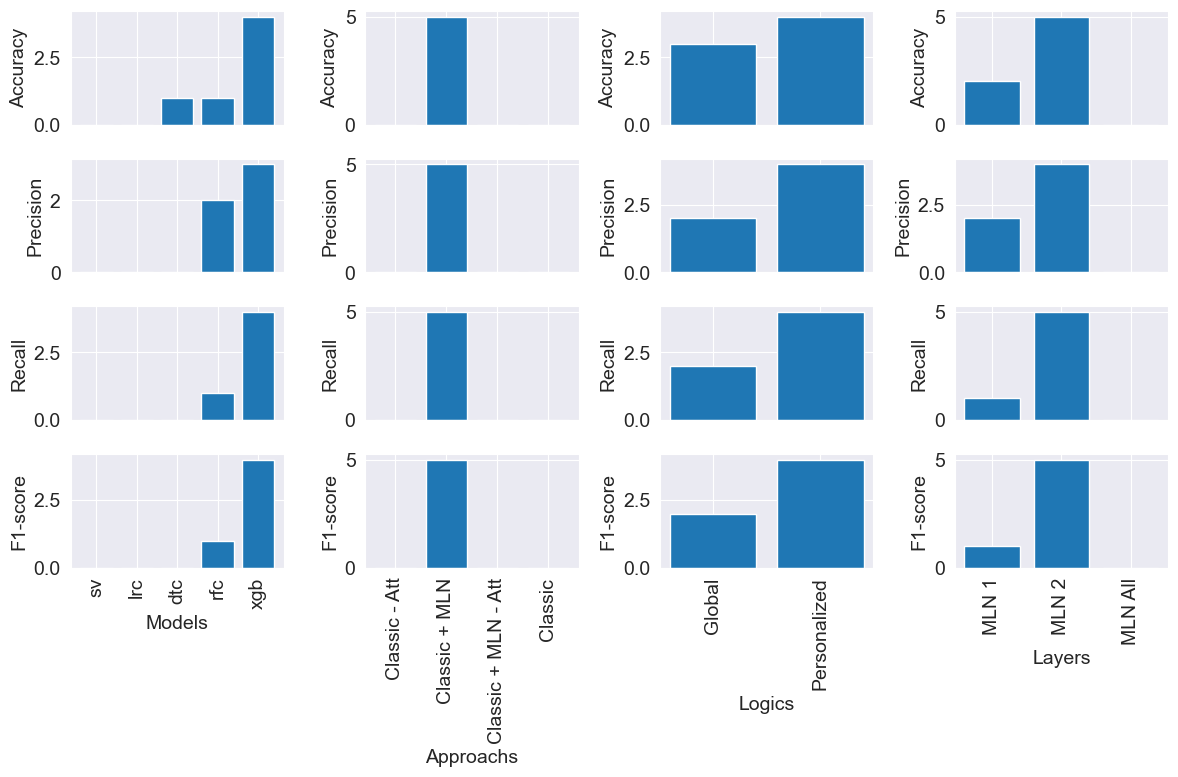

In [33]:
analyzer_launcher_best_computation(outputs_name="outputs_16032024", analytical_func=metrics_analyzer_statistics_tab_f_7, layers=layers, approach=approach)